In [1]:
import requests
import os
from dotenv import load_dotenv
from utils.tavily.core import web_api
from utils.snowflake.core import chart_api
from utils.litellm.core import llm
from utils.helper import sf_system_prompt, ra_system_prompt
from langchain.tools import tool
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from operator import add

load_dotenv()


# Define AgentState
class State(TypedDict):
    web: dict
    rag: dict
    sf: dict
    llm_operations: Annotated[list[dict], add ]
    model_responses: Annotated[list[dict], add]
    web_search_result: str
    rag_search_result: str
    sf_search_result : list
    combined_output: tuple

In [2]:
def sf_llm_call(state: State):
    print(f"calling agg llm' {state['llm_operations']}")
    input_params = state['llm_operations'][-1]
    response = llm(**input_params)['answer']
    return {'model_responses':[{ 'answer': response}]}

In [3]:
def agg_llm_call(state: State):
    print(f"calling agg llm' {state['llm_operations']}")
    input_params = state['llm_operations'][-1]
    response = llm(**input_params)['answer']
    return {'model_responses':[{ 'answer': response}]}

In [4]:
def sf_search(state: State):
    print('calling snowflake search tool')
    input_params = {'raw_json_string':state['model_responses'][0]['answer']}
    chart_data = chart_api(**input_params)
    return {"sf_search_result": chart_data}

In [5]:
def web_search(state: State):
    """
    Performs a web search using the Tavily API and returns filtered, high-quality search results.

    Args:
        query (str): The search query.
        num_results (int, optional): The maximum number of results to return. Defaults to 5.
        score_threshold (float, optional): The minimum relevance score required for a result to be included. Defaults to 0.7.

    Returns:
        str: A formatted string containing the top search results, including titles, snippets, and links.

    Functionality:
        - Sends a search request to the Tavily API.
        - Filters results based on a score threshold to ensure relevance.
        - Sorts results in descending order of relevance.
        - Extracts titles, snippets, and URLs from the filtered results.
        - If no results meet the threshold, returns the highest-scoring result available.
        - Includes image URLs (though they are not currently returned in the final output).

    Example:
        >>> enhanced_search("latest AI advancements", num_results=3)
        "Title: AI Breakthroughs in 2024\nSnippet: Researchers have discovered...\nLink: https://example.com\n---\nTitle: OpenAI's New Model\nSnippet: OpenAI has released...\nLink: https://example.com"
    """
    print('calling web search tool')
    input_params = state['web']
    context = web_api(**input_params)
    return {"web_search_result": context}
    

In [6]:
from utils.pytract.core import pytract_rag
from langchain.tools import tool
def rag_search(state:State) -> str:
    """
    Searches a vector database using the specified search parameters and query, and returns the retrieved context.
    
    The function utilizes the year and quarter information from the search parameters to perform the search 
    and retrieve relevant context, which can be used for further text generation by the specified model.

    Args:
        search_params (list[dict]): A list of dictionaries containing search parameters, such as year and quarter information.
        query (str): The search query to find relevant data from the database.
        model (str): The model name or identifier used to process the search results.

    Returns:
        str: The retrieved context from the database relevant to the query, used for text generation.

    Example:
        result = rag_tool([{'year': 2025, 'qtr': 1}], "What were the financial highlights?", "nvidia-model")
        print(result)  # Prints the context retrieved from the database for further processing.
    """
    print('calling rag search tool')
    input_params = state['rag']
    nvidia_rag = pytract_rag()
    context = nvidia_rag.run_nvidia_text_generation_pipeline(**input_params)
    return {"rag_search_result": context}


d:\NEU\SPRING_25\BIG_DATA\agentic-rag\backend\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def aggregator(state: State):
    """Combine the results in to generate a user prompt"""
    print('calling aggregator')
    model = state['llm_operations'][0]['model']
    rag_result = state['rag_search_result']
    web_result = state['web_search_result']
    return {"llm_operations": [{"model":model,"user_prompt": f"rag result:\n{rag_result}\n--------\nweb result:\n{web_result}", "system_prompt":ra_system_prompt}]}

In [8]:
def final_report(state:State):
    """Combine the results in to generate a research report"""  
    print('calling final report') 
    report_markdown = state['model_responses'][-1]['answer']
    # print(state)
    chart_data = state['sf_search_result']
    return {'combined_output': (report_markdown, chart_data)}

In [10]:
parallel_builder = StateGraph(State)
parallel_builder.add_node("rag_search", rag_search)
parallel_builder.add_node("web_search", web_search)
parallel_builder.add_node("sf_search", sf_search)
parallel_builder.add_node("sf_llm_call", sf_llm_call)
parallel_builder.add_node("agg_llm_call", agg_llm_call)
parallel_builder.add_node("aggregator", aggregator)
parallel_builder.add_node("final_report", final_report)

parallel_builder.add_edge(START, "rag_search")
parallel_builder.add_edge(START, "web_search")
parallel_builder.add_edge(START, "sf_llm_call")  
parallel_builder.add_edge("sf_llm_call", "sf_search") 

parallel_builder.add_edge(["rag_search", "web_search"], "aggregator")
parallel_builder.add_edge("aggregator", "agg_llm_call") 

parallel_builder.add_edge(["sf_search", "agg_llm_call"], "final_report")  # Combine everything at final report

parallel_builder.add_edge("final_report", END)

parallel_workflow = parallel_builder.compile()


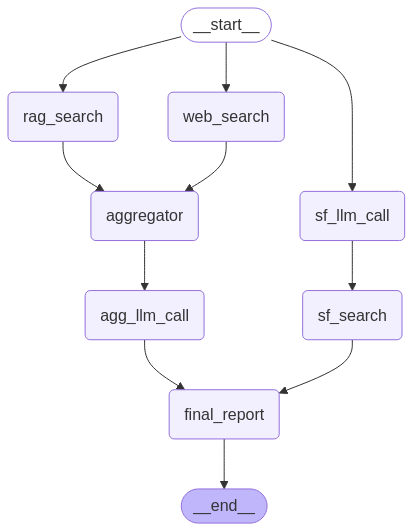

In [11]:
from IPython.display import Image, display
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))


In [12]:
initial_state = {
    "llm_operations":[{"model":"gemini/gemini-1.5-pro", "user_prompt":"how did nvidia revenue surge from 2024 to 2025", "system_prompt":sf_system_prompt, "is_json": True}],
    "sf": {"query": "how did nvidia revenue surge from 2024 to 2025"},
    "web" :{"query": "Who is batman", "num_results": 5, "score_threshold": 0.7},
    "rag" : {"search_params": [{"year":"2025", "qtr":"1"}], "query": "what is nvidia's risks"}
}

output_state = parallel_workflow.invoke(initial_state)

calling rag search tool
calling agg llm' [{'model': 'gemini/gemini-1.5-pro', 'user_prompt': 'how did nvidia revenue surge from 2024 to 2025', 'system_prompt': '\nYou are a structured data extraction agent. Your task is to identify relevant financial metrics from a user prompt and map them to the provided Snowflake schema.  \n\n### Instructions:  \n\n1. **Analyze User Input**  \n   - Identify keywords or financial terms in the prompt that match the schema.  \n   - If the query explicitly mentions specific metrics (e.g., "revenue"), return only those columns.  \n   - If the query is generalized (e.g., "valuation metrics" or "financial performance"), return ALL columns in the schema.  \n   - If the query does not reference any relevant financial metrics, return an empty list.  \n\n2. **Map to Snowflake Schema**  \n   - Match the user request to the following column names:  \n     ```\n     ["MARKET_CAP", "ENTERPRISE_VALUE", "TRAILING_PE", "FORWARD_PE", \n     "PEG_RATIO", "SALES_PRICE", "

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sathy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


calling snowflake search toolcalling aggregator

calling agg llm' [{'model': 'gemini/gemini-1.5-pro', 'user_prompt': 'how did nvidia revenue surge from 2024 to 2025', 'system_prompt': '\nYou are a structured data extraction agent. Your task is to identify relevant financial metrics from a user prompt and map them to the provided Snowflake schema.  \n\n### Instructions:  \n\n1. **Analyze User Input**  \n   - Identify keywords or financial terms in the prompt that match the schema.  \n   - If the query explicitly mentions specific metrics (e.g., "revenue"), return only those columns.  \n   - If the query is generalized (e.g., "valuation metrics" or "financial performance"), return ALL columns in the schema.  \n   - If the query does not reference any relevant financial metrics, return an empty list.  \n\n2. **Map to Snowflake Schema**  \n   - Match the user request to the following column names:  \n     ```\n     ["MARKET_CAP", "ENTERPRISE_VALUE", "TRAILING_PE", "FORWARD_PE", \n     "PEG

In [13]:
output_state['combined_output']

('```python\nimport requests\nfrom IPython.display import Image, display\n\ndef build_report(research_output):\n    """Formats the research output into a readable report."""\n\n    report = ""\n    report += "## Introduction\\n" + research_output["introduction"] + "\\n\\n"\n    report += "## Research Steps\\n"\n    for step in research_output["research_steps"]:\n        report += "- " + step + "\\n"\n    report += "\\n"\n    report += "## Main Body\\n" + research_output["main_body"] + "\\n\\n"\n    report += "## Conclusion\\n" + research_output["conclusion"] + "\\n\\n"\n    report += "## Sources\\n"\n    for source in research_output["sources"]:\n        report += "- " + source + "\\n"\n\n    return report\n\n\n\ndef research_agent(query):\n\n    web_results = {\'filtered_results\': [{\'url\': \'https://variety.com/2025/film/news/ben-affleck-batman-excruciating-experience-1236347358/\', \'title\': \'Ben Affleck Says ‘I’ve Lost Interest’ in Superhero Movies and Batman Skewed So Old That

In [ ]:
from utils.pytract.core import pytract_rag
nvidia_rag = pytract_rag()
context = nvidia_rag.run_nvidia_text_generation_pipeline([{'year': "2025", 'qtr': "1"}], 'what are the risks metioned')

In [3]:
data=web_api('how did nvidia perform for 2022 q1 in revenue and PEG Ratio? generate a detailed step by step research report arriving to each conclusion')

In [7]:
import tiktoken

def count_tokens(text, model="gpt-4"):
    enc = tiktoken.encoding_for_model(model)
    return len(enc.encode(text))

print(count_tokens(str(data)))


1935


In [5]:

data

{'filtered_results': [{'url': 'https://www.investopedia.com/amd-nvidia-lead-chip-stock-rally-as-semiconductor-tariff-worries-ease-11702313',
   'title': 'AMD, Nvidia Lead Chip-Stock Rally as Semiconductor Tariff Worries Ease - Investopedia',
   'score': 0.18016468,
   'published_date': 'Mon, 24 Mar 2025 19:29:31 GMT',
   'content': "Advanced Micro Devices (AMD), Nvidia (NVDA), and other chip stocks rallied Monday following reports the Trump administration may not target the semiconductor industry as part of the tariffs scheduled to take effect on April 2. Tesla, Nvidia Lead Tech Stock Rally Wednesday After Soft Inflation Data AMD Stock Climbs as Chipmaker's Gaming GPUs Gain Market Share in Japan Microchip Technology Moves to Sell Facility, Launches $1.35B Stock Offering Nvidia Stock Held Up Better Than Mag 7 Peers During Thursday's Rout—Watch These Key Levels AI Stocks Rebound with 'Fundamentals Still Intact,' Says UBSWatch These Micron Price Levels as Stock Rises After AI-Driven Earni

In [ ]:
from utils.litellm.core import llm
from utils.helper import sf_system_prompt
data=llm(model='gemini/gemini-1.5-pro', system_prompt=sf_system_prompt, user_prompt="how did nvidia revenue and p/e trailing performed in 2021 q1", is_json=True )

In [ ]:
import json
print(json.loads(data['answer']))
print(eval(data['answer']))

In [ ]:
from utils.snowflake.core import get_chart_data
from dotenv import load_dotenv
load_dotenv()

In [ ]:
data=get_chart_data(data['answer'])

In [ ]:
from openai import OpenAI
client = OpenAI()

response = client.images.generate(
    model="dall-e-3",
    prompt=f"generate the image for this dataframe \n{data[0]}",
    size="1024x1024",
    quality="standard",
    n=1,
)

print(response.data[0].url)

In [2]:
from utils.helper import report_user_prompt

In [4]:
report_user_prompt.format('happy', 'birthday', 'toyou')

"\nYou have been provided with research data from two sources:\n\n### RAG (Retrieval-Augmented Generation) Results:\nhappy\n\n### Web Search Results:\nbirthday\n\nUsing the above information, generate a research report that answers the following question:\n\n**User's Question:** toyou\n\nEnsure the response is comprehensive, well-structured, and aligns with the research framework outlined in the system prompt.\n"

In [1]:
import snowflake.connector as sf
from dotenv import load_dotenv
import os 
import json
import pandas as pd
from dotenv import load_dotenv

load_dotenv("D:\\NEU\SPRING_25\\BIG_DATA\\agentic-rag\\backend\\.env")
conn = sf.connect(
user=os.getenv('SF_USER'),
password=os.getenv('SF_PASSWORD'),
account=os.getenv('SF_ACCOUNT'),
warehouse="AGENT_WH",
database="AGENT_DB",
schema="AGENT_SH",
role="AGENT"
)

<>:8: SyntaxWarning: invalid escape sequence '\S'
<>:8: SyntaxWarning: invalid escape sequence '\S'
C:\Users\sathy\AppData\Local\Temp\ipykernel_24496\2831943091.py:8: SyntaxWarning: invalid escape sequence '\S'
  load_dotenv("D:\\NEU\SPRING_25\\BIG_DATA\\agentic-rag\\backend\\.env")


In [3]:
import pandas as pd
from dotenv import load_dotenv
import os 
from snowflake.connector.pandas_tools import write_pandas
from datetime import datetime
from dateutil.relativedelta import relativedelta
from firecrawl import FirecrawlApp
import re

app = FirecrawlApp(api_key=os.getenv('FIRECRAWL_API_KEY'))
cursor = conn.cursor()

def get_year_and_qtr(date_str):
    if date_str == 'Current':
        today = datetime.today() - relativedelta(months=1)
    else:
        today = pd.to_datetime(date_str, errors='coerce') - relativedelta(months=1)

    year = today.year
    qtr = (today.month - 1) // 3 + 1
    return year, qtr



def etl_snowflake():
    response = app.scrape_url(url='https://finance.yahoo.com/quote/NVDA/key-statistics/', params={
        'formats': [ 'markdown' ],
        'includeTags': [ 'table' ]
    })

    # Assuming `response['markdown']` contains your Markdown table
    data = response['markdown']

    # Regex pattern to extract the Markdown table
    pattern = r"(\|.*?Current.*?\|\n\|.*?\|\n(?:\|.*?\|\n)+)"

    # Search for the table in the text
    match = re.search(pattern, data, re.DOTALL)

    if match:
        table_text = match.group(1)  
        rows = [row.strip() for row in table_text.split("\n") if row.strip()]
        data = [row.strip('|').split('|') for row in rows]
        df = pd.DataFrame(data[1:], columns=data[0])  # Skip first two rows
        df.columns = [col.strip() for col in df.columns]
    
    df.rename(columns={'': 'column'}, inplace=True)
    df_cleaned = df.iloc[1:].reset_index(drop=True)
    df_cleaned.set_index('column', inplace=True)

    df_transposed = df_cleaned.transpose()
    df_transposed[' Market Cap '] = (df_transposed[' Market Cap '].astype(str).str.replace('T', '', regex=False).astype(float).round(2))
    df_transposed[' Enterprise Value '] = (df_transposed[' Enterprise Value '].astype(str).str.replace('T', '', regex=False).astype(float).round(2))
    # df_transposed_reset = df_transposed.reset_index()
    df_transposed=df_transposed.reset_index().rename(columns={'index': 'DATE_PERIOD'})
    df_transposed.columns=["DATE_PERIOD","MARKET_CAP","ENTERPRISE_VALUE","TRAILING_PE","FORWARD_PE","PEG_RATIO","SALES_PRICE","BOOK_PRICE","REVENUE","EBITDA"]

    df_transposed[['YEAR', 'QTR']] = df_transposed['DATE_PERIOD'].apply(lambda x: pd.Series(get_year_and_qtr(x)))
    cursor = conn.cursor()
    cursor.execute('TRUNCATE TABLE VALUATION_METRICS')
    success, num_chunks, num_rows, _ = write_pandas(conn, df_transposed, "VALUATION_METRICS")
    
    return success

In [4]:
cursor = conn.cursor()

In [ ]:
data=cursor.execute('select *  from valuation_metrics')

In [8]:
data.fetchall()

[('Current',
  2.94,
  2.91,
  41.05,
  26.88,
  1.16,
  22.94,
  37.12,
  22.31,
  33.81,
  2025,
  1),
 ('1/31/2025',
  2.94,
  2.91,
  47.4,
  28.09,
  0.86,
  26.36,
  44.62,
  25.71,
  38.9,
  2024,
  4),
 ('10/31/2024',
  3.25,
  3.23,
  62.24,
  33.9,
  1.03,
  34.33,
  55.95,
  33.53,
  51.27,
  2024,
  3),
 ('7/31/2024',
  2.87,
  2.85,
  68.47,
  44.64,
  1.33,
  36.58,
  58.49,
  35.78,
  56.32,
  2024,
  2),
 ('4/30/2024',
  2.13,
  2.11,
  72.42,
  35.71,
  1.16,
  35.37,
  49.45,
  34.64,
  59.31,
  2024,
  1),
 ('1/31/2024',
  1.52,
  1.51,
  81.17,
  30.4,
  0.6,
  34.14,
  45.57,
  33.63,
  66.16,
  2023,
  4)]